In [2]:
from BinanceTrade import *
import StrategyBackTest
import matplotlib.pyplot as plt

In [51]:
# 코인 설정
ticker = "DOGEUSDT"
interval = "15m"
start_date = "2021-06-01"
end_date = "2023-01-01"
df=get_all_ohlcv(
    symbol=ticker, 
    interval=interval, 
    start_date=datetime.datetime.strptime(start_date, "%Y-%m-%d"), 
    end_date=datetime.datetime.strptime(end_date, "%Y-%m-%d"),
    )

# 전략 설정
length=14
change_percentage=1.4
below=55
above=100
strategy_df = strategy_vwma_long(
    df=df,
    length=length,
    change_percentage=change_percentage,
    below=below,
    above=above,
    )

print(f"{ticker} {interval} \n{start_date} ~ {end_date}")

DOGEUSDT 15m 
2021-06-01 ~ 2023-01-01


In [52]:
# 백테스트 시작
start_balance =10000.0 # 시작 자산
fee = 0.0005    # 수수료
dca = -0.02  # 분할매수 진입 최소 수익률 
dca_levels = [0.3,0.5,1.0]      # 분할매수 비율
mtp = -1    # Min Take Profit 매도시 최소 수익률 (미사용 시 -1)
stl = -1    # Stop Loss (미사용 시 -1)
backtest_df = StrategyBackTest.DCABackTest(
    data=strategy_df,
    start_balance=start_balance,
    fee=fee,
    dca=dca,
    dca_levels=dca_levels,
    mtp=mtp,
    stl=stl,
    )

매수 횟수: 1073번
매도 횟수: 634번
매매 최고 수익률: 11.264%
MDD: -37.908%
최저 수익률: -34.642%
최고 수익률: 68.029%
최종 수익률: 45.284%


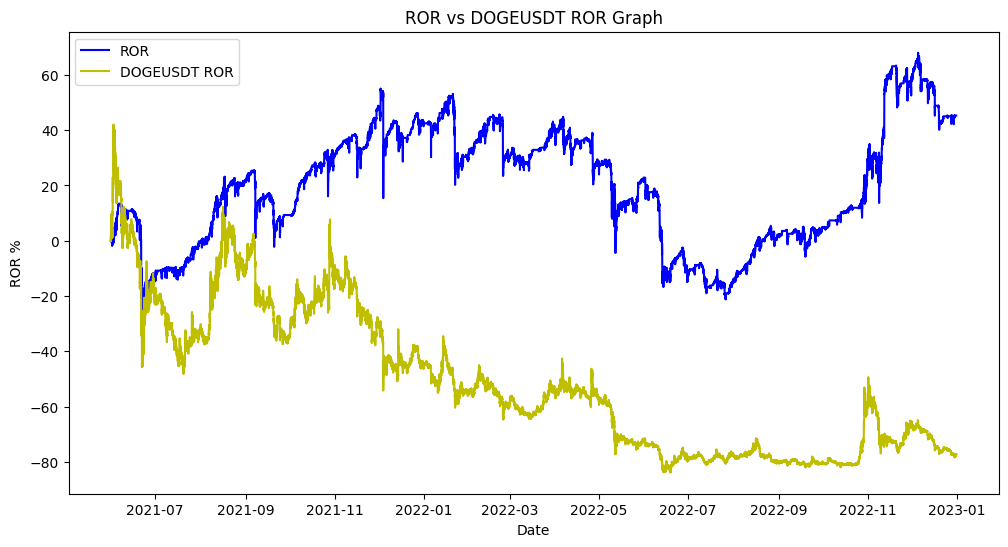

In [53]:
# 수익률 비교
backtest_df[f'{ticker} ROR'] = (backtest_df['Close'] / backtest_df['Close'].iloc[0] - 1) * 100
plt.figure(figsize=(12, 6))
plt.plot(backtest_df['Time'], backtest_df['총수익률'], label='ROR', color='b', linestyle='-')
plt.plot(backtest_df['Time'], backtest_df[f'{ticker} ROR'], label=f'{ticker} ROR', color='y', linestyle='-')
plt.plot()
plt.title(f'ROR vs {ticker} ROR Graph')
plt.xlabel('Date')
plt.ylabel('ROR %')
plt.legend()
plt.show()

In [17]:
# 엑셀로 출력
strategy_name = "VWMA_LONG"
now = datetime.datetime.now()
backtest_df.to_excel(f"backtest/[{strategy_name}]BackTest_{ticker}{interval}.xlsx")

In [56]:
import pandas as pd
import talib

def cdc_trailing_stop_strategy(df, short_ema_period, long_ema_period, atr_period, atr_multiplier, profit_target_multiplier):
    # Calculate EMA
    df['Short_EMA'] = talib.EMA(df['Close'], timeperiod=short_ema_period)
    df['Long_EMA'] = talib.EMA(df['Close'], timeperiod=long_ema_period)
    
    # Calculate MACD
    macd, signal, _ = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['Signal'] = signal
    
    # Calculate ATR
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=atr_period)
    
    # Calculate CDC Trailing Stop ATR levels
    df['CDC_Trailing_Stop_Long'] = df['Close'] - (df['ATR'] * atr_multiplier)
    df['CDC_Trailing_Stop_Short'] = df['Close'] + (df['ATR'] * atr_multiplier)
    
    # Initialize variables
    position = 0  # 0: No Position, 1: Long, -1: Short
    profit_target_price = 0
    
    # Generate signals and execute trades
    for i in range(1, len(df)):
        if (
            df.at[i, 'Close'] > df.at[i, 'Short_EMA'] and
            df.at[i, 'Short_EMA'] > df.at[i, 'Long_EMA'] and
            df.at[i, 'MACD'] > df.at[i, 'Signal'] and
            df.at[i, 'Close'] > df.at[i, 'CDC_Trailing_Stop_Long']
        ):
            # Long (Buy) Entry
            if position != 1:
                position = 1
                profit_target_price = df.at[i, 'Close'] + (df.at[i, 'ATR'] * profit_target_multiplier)
        
        elif (
            df.at[i, 'Close'] < df.at[i, 'Short_EMA'] and
            df.at[i, 'Short_EMA'] < df.at[i, 'Long_EMA'] and
            df.at[i, 'MACD'] < df.at[i, 'Signal'] and
            df.at[i, 'Close'] < df.at[i, 'CDC_Trailing_Stop_Short']
        ):
            # Short (Sell) Entry
            if position != -1:
                position = -1
                profit_target_price = df.at[i, 'Close'] - (df.at[i, 'ATR'] * profit_target_multiplier)
        
        # Check exit conditions
        if position == 1 and (df.at[i, 'Close'] >= profit_target_price or df.at[i, 'Close'] < df.at[i, 'CDC_Trailing_Stop_Long']):
            position = 0  # Long Exit
        
        elif position == -1 and (df.at[i, 'Close'] <= profit_target_price or df.at[i, 'Close'] > df.at[i, 'CDC_Trailing_Stop_Short']):
            position = 0  # Short Exit
        
        df.at[i, 'Position'] = position
    
    return df

bt = cdc_trailing_stop_strategy(df, short_ema_period=60, long_ema_period=90, atr_period=14, atr_multiplier=2.0, profit_target_multiplier=1.5)


In [59]:
# 백테스트 시작
start_balance =10000.0 # 시작 자산
fee = 0.0005    # 수수료
dca = -0.02  # 분할매수 진입 최소 수익률 
dca_levels = [0.3,0.5,1.0]      # 분할매수 비율
mtp = -1    # Min Take Profit 매도시 최소 수익률 (미사용 시 -1)
stl = -1    # Stop Loss (미사용 시 -1)
backtest_df = StrategyBackTest.DCABackTest(
    data=bt,
    start_balance=start_balance,
    fee=fee,
    dca=dca,
    dca_levels=dca_levels,
    mtp=mtp,
    stl=stl,
    )

매수 횟수: 1073번
매도 횟수: 634번
매매 최고 수익률: 11.264%
MDD: -37.908%
최저 수익률: -34.642%
최고 수익률: 68.029%
최종 수익률: 45.284%


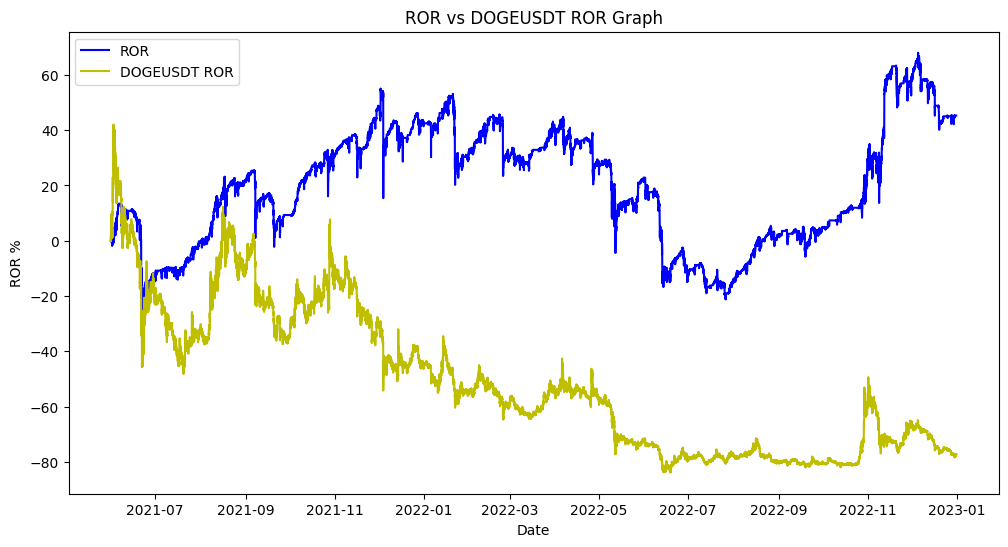

In [60]:
# 수익률 비교
backtest_df[f'{ticker} ROR'] = (backtest_df['Close'] / backtest_df['Close'].iloc[0] - 1) * 100
plt.figure(figsize=(12, 6))
plt.plot(backtest_df['Time'], backtest_df['총수익률'], label='ROR', color='b', linestyle='-')
plt.plot(backtest_df['Time'], backtest_df[f'{ticker} ROR'], label=f'{ticker} ROR', color='y', linestyle='-')
plt.plot()
plt.title(f'ROR vs {ticker} ROR Graph')
plt.xlabel('Date')
plt.ylabel('ROR %')
plt.legend()
plt.show()